# WoW subscriber count over time
## Goals
 - Estimate wow sub numbers for after blizzard stopped announcing them
 - Show a timeline of changes made and try to explain how they affected subscriber count

## Estimating sub count

Blizzard only announced sub numbers from 2005 - 2015 and stopped releasing them once they started to drop. Let's see if we can estimate the sub count using google trends data and Blizzards revenue from their quarterly earning reports.

In [1]:
import pandas as pd
import numpy as np

# Load in subs, google trends and revenue data
subs = pd.read_csv('Blizz Data - Subs.csv', header=None)
trends = pd.read_csv('wowtrendsFinal.csv',header=0)
rev = pd.read_csv('revenue.csv')


#add column names
subs.rename(columns={0:'Quarter',1:'Millions of Subscribers'}, inplace=True)

#convert index to datetime
subs['Quarter'] = pd.to_datetime(subs['Quarter'])
subs['Quarter'] = subs['Quarter'].dt.to_period('Q')
subs = subs.set_index('Quarter')




In [2]:
#Clean the revenue df for easy merging
rev = rev[['Quarter','Revenue']]
rev['Quarter'] = pd.to_datetime(rev['Quarter'])
rev['Quarter'] = rev['Quarter'].dt.to_period('Q')
rev = rev.set_index('Quarter')

The main feature we'll be using for this model is google trends data as well as blizzards total revenue. The revenue will lead to a bit of innacuracy because of other Blizzard games like Overwatch, Diablo and Starcraft also included in Blizzards revenue. This shouldn't matter too much as we care more about the overall trends of the subscriber count rather than precise subscriber counts. Here are the google trends search terms we're looking at as well as the mean of those plotted against released subscriber count numbers.

In [3]:

#Lets add the mean interest as a feature and to make plotting easier.
trends = trends.assign(mean=trends.mean(axis=1, numeric_only=True).round(2))
trends['Quarter'] = pd.to_datetime(trends['Quarter'])
trends['Quarter'] = trends['Quarter'].dt.to_period('Q')
trends = trends.rename(columns={'mean':'trends_mean'})

trends.head()

,Quarter,wow guide: (United States),wow leveling: (United States),wow priest: (United States),wow shaman: (United States),wow dk: (United States),wow druid: (United States),wow hunter: (United States),wow mage: (United States),wow paladin: (United States),wow pvp: (United States),wow rogue: (United States),wow: (United States),wow warlock: (United States),wow warrior: (United States),trends_mean
0,2004Q4,5.7,2.7,14.7,11.3,0.0,8.3,11.7,6.0,11.0,4.0,14.0,14.7,15.3,11.7,9.36
1,2005Q1,10.3,6.3,20.3,23.3,2.7,19.0,24.0,15.0,23.0,13.0,21.7,25.3,27.0,18.7,17.83
2,2005Q2,13.0,11.7,36.0,31.0,4.3,27.3,32.3,24.3,18.7,28.0,32.7,31.3,26.7,26.7,24.57
3,2005Q3,18.3,16.7,38.3,23.3,2.0,25.7,39.7,34.7,28.3,27.0,43.0,39.0,36.7,31.3,28.86
4,2005Q4,22.3,22.0,42.7,29.0,0.0,38.3,55.0,32.3,29.7,41.3,42.7,44.0,34.0,40.0,33.81


<AxesSubplot:xlabel='Quarter'>

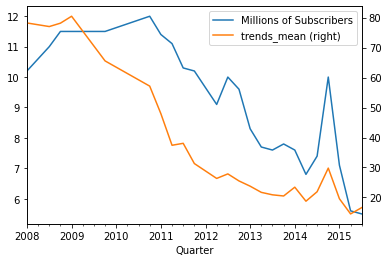

In [4]:
#Merging data frames and plotting mean google trends data vs official Blizzard subscriber counts
df = trends.merge(subs, on='Quarter',how='right')

df = df.merge(rev, on='Quarter', how='inner')

df.plot(x='Quarter',y=['Millions of Subscribers','trends_mean'],secondary_y='trends_mean')


These features seem correlated to subscriber count and should have decent predictive power. Let's prepare these features for model training. 

In [5]:
#Create a lag feature with the previous quarters sub count
df = df.set_index('Quarter')
df['1q_lag'] = df['Millions of Subscribers'].shift(1)

#Split the target (Subscriber Count) from the features
y = df['Millions of Subscribers']
X = df.drop(columns='Millions of Subscribers')
df.head()

,wow guide: (United States),wow leveling: (United States),wow priest: (United States),wow shaman: (United States),wow dk: (United States),wow druid: (United States),wow hunter: (United States),wow mage: (United States),wow paladin: (United States),wow pvp: (United States),wow rogue: (United States),wow: (United States),wow warlock: (United States),wow warrior: (United States),trends_mean,Millions of Subscribers,Revenue,1q_lag
Quarter,,,,,,,,,,,,,,,,,,
2008Q1,69.3,71.3,89.3,89.3,0.7,80.3,90.7,83.3,86.0,75.0,86.0,88.7,94.7,90.3,78.21,10.2,280,NaN
2008Q3,60.3,74.3,86.7,91.7,2.3,91.7,87.0,86.7,87.7,68.7,86.3,82.7,86.7,85.3,77.01,11.0,297,10.2
2008Q4,79.3,88.0,78.7,74.7,40.7,83.3,86.7,81.0,93.0,59.7,74.0,95.3,80.3,79.3,78.14,11.5,475,11.0
2009Q1,86.3,89.0,80.7,91.0,77.0,82.7,84.3,85.3,90.0,53.0,71.0,87.0,77.7,71.3,80.45,11.5,291,11.5
2009Q4,56.3,58.0,66.7,81.7,65.3,74.0,68.7,64.3,81.3,52.7,56.3,67.0,63.7,61.7,65.55,11.5,328,11.5


In [6]:
#Rename columns into numbers just to have a cleaner dataframe
for col in range(len(X.columns.values)):
    X.columns.values[col] = col

In [7]:
#split data for training and testing
n = len(df)
X_train, y_train = X[1:int(n*.8)], y[1:int(n*.8)]
X_test, y_test = X[int(n*.8):], y[int(n*.8):]


Let's train a model on this data and see how well it scores for accuracy.

In [8]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=100000, 
                       early_stopping_rounds=100,
                       learning_rate = 0.001,
                      reg_alpha= 1)
reg.fit(X_train, y_train, 
       eval_set=[ (X_train,y_train),(X_test,y_test)],
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=1, reg_lambda=1, ...)

In [9]:

print('Accuracy on test set:', round(reg.score(X_test,y_test),2))
print('Accuracy on training set:', round(reg.score(X_train, y_train),2))

Accuracy on test set: 0.82
Accuracy on training set: 0.78


This looks decent for our small data set, let's train on all the data we have since our sample size is so small and see how that projects out into the future. It will definitely overfit a bit but again we are more interested in the greater trends rather than accurate subscriber numbers.

In [10]:

reg = xgb.XGBRegressor(n_estimators=100000, 
                       early_stopping_rounds=100,
                       learning_rate = 0.001,
                      reg_alpha= 1)
reg.fit(X, y, 
       eval_set=[ (X_train,y_train),(X_test,y_test)],
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=1, reg_lambda=1, ...)

In [11]:
# New data frame with all trends and revenue data we have
df = trends.merge(rev, on='Quarter',how='inner')
df = df.merge(subs, on='Quarter',how='left')

#lag feature creation
df['1q_lag'] = df['Millions of Subscribers'].shift(1)
df = df.set_index('Quarter')


In [12]:
#Create our X and ys for graphing
X = df.drop(columns='Millions of Subscribers')
y = df['Millions of Subscribers'].dropna()

for col in range(len(X.columns.values)):
    X.columns.values[col] = col

In [13]:
preds = []
#for loop to predict one row at a time and add that prediction to the next row
for i in range(len(X)):
    X_array = pd.DataFrame(X.iloc[i]).T
    X_array = X_array.values
    pred = reg.predict(X_array)
    pred = pred[0]
    preds.append(pred)
    if i < (len(X)-1):
        X.iloc[i+1,-1] = pred
    
    
    

### Let's take a look at feature importance.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

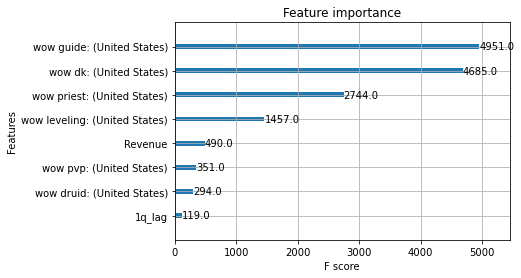

In [32]:
#Plot feature importance
feature_names = list(df.columns.values)
feature_names.pop(-2)
reg.get_booster().feature_names = feature_names
xgb.plot_importance(reg.get_booster())

It's surprising which features are being prioritized. Feature selection might be improved by including global Google trends and only using the mean of all search terms.

### Let's graph actual vs predicted.

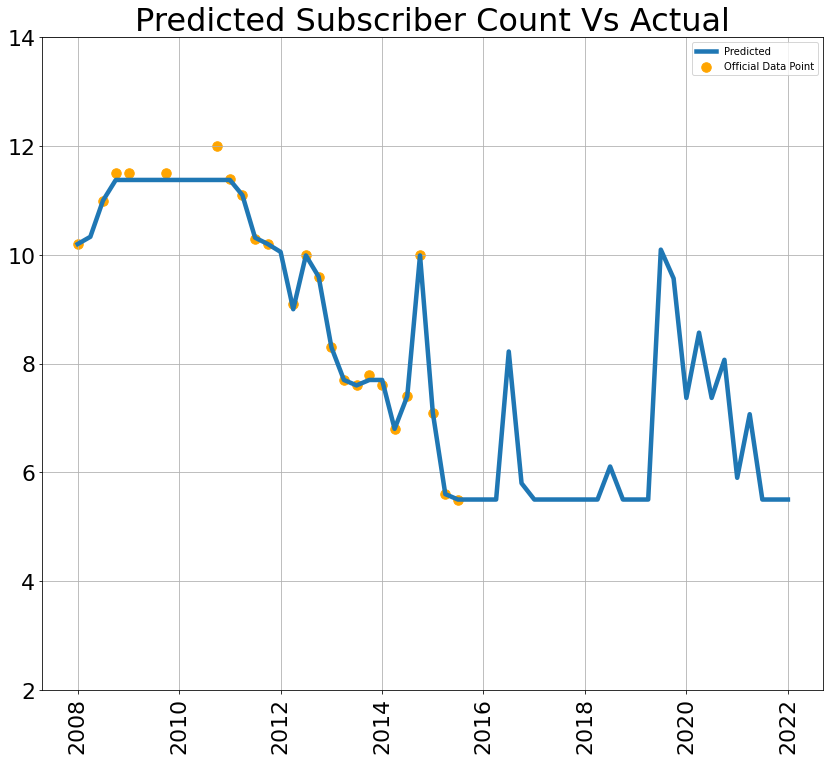

In [14]:

import matplotlib.pyplot as plt
x = X.index.to_timestamp()
#x = str(df.index.values)
fig, ax = plt.subplots(1,1, figsize=(14,12))
plt.xticks(rotation=90)
plt.plot(x,preds,label='Predicted', linewidth=4.5,)
plt.scatter(x, df['Millions of Subscribers'],color='orange',label='Official Data Point', s=90)
plt.legend()
plt.title(label='Predicted Subscriber Count Vs Actual', size=32)
plt.grid()
ax.set_ylim([2,14])
ax.tick_params(axis='both', labelsize=22)


# Conclusions

 The data does look overfit but I don't think finding the exact number of subs is as important for our analysis as the general trend. There's a lot of information that makes it really hard to find out the exact numbers such as releases of other games.

The biggest spikes on this graph are from expansions releasing and WoW classic servers releasing. Let's visualize that.

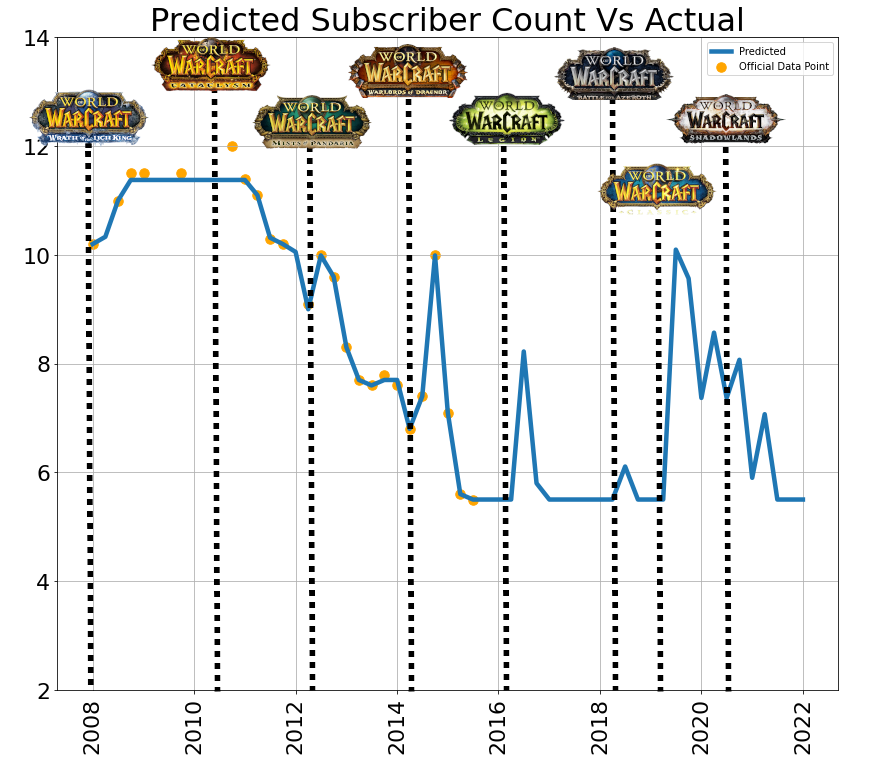

The biggest jumps and subsequently biggest falls happen after expansion releases. This makes sense, more of the world to explore, more dungeons to conquer and more adventures to be had. The only exception here is Wrath of the Lich king, the first expansion pictures in which the subscriber count climbed to near all time highs and held. Lets break it down expansion by expansion and see what about the expansion made it a success or failure.

### Wrath of the Lich King (WotLK or Wrath)
This was the second expansion for WoW, The Burning Crusade (TBC from here on out) not being pictured above due to lack of a few data points. Before this expansion it was a pretty steady growth looking a lot like a logarithmic growth curve up until Wrath pictured below.

<AxesSubplot:title={'center':'Official Blizzard Subscriber Numbers'}, xlabel='Quarter'>

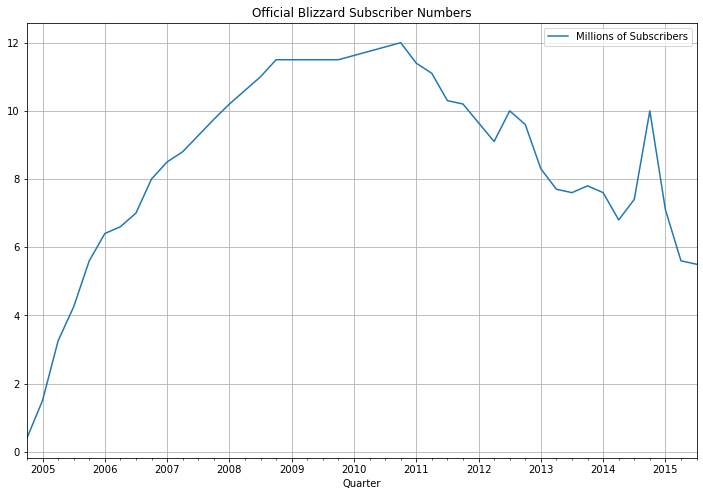

In [15]:

subs.plot(figsize=(12,8), grid=True, title='Official Blizzard Subscriber Numbers')

#### What made WotLK so good?
Most would agree what made Wrath so popular was accessibility. Blizzard did away with a lot of the barriers to entry that were previously in the base version of the game and TBC. The game was sped way up compared to versions of the game prior. You no longer had to complete a long series of tasks to even enter dungeons or raids (attunement). Grinds like rank 14 no longer existed which took players on average months playing 10 hours a day. Class power and viability improved over the board allowing the player more options and from those options a more enjoyable experience. Dual talent specilization removing friction from participating in multiple forms of content rather than having to specialize for just one portion of the game. This led to a smaller gap between the elite and the average player, at least in terms of potential. 

While Wrath did close this gap it didn't erradicate it, and in the MMO genre I think that's very important. You want to feel rewarded when you put in that extra effort. With this expansion Blizzard introduced achievements and hard-mode content with special rewards, letting everyone know that you had put in that extra time or your team had played a certain raid better with more challenging circumstances. For perspective, Alone in the Darkness a boss encounter hard-mode was only completed by 10 guilds (25 players each, totaling 250 players) of WoW's 12 million subscribers at the time. However it was still enjoyable to be that casual player. Just clearing bosses and getting loot while not worrying about the special rewards was enough for the average player to enjoy their time in game.

As a casual player you could still access the content hardcore players were playing, and got similar rewards. Sure you might not get that cool mount or title next to your name but you still had a full set of epic gear. Wrath had also experienced the largest amount of the subscriber base raiding at any time according to Blizzard. Blizzard had found the goldilocks zone of rewarding casual players vs hardcore players. It just felt good to play the game, regardless of how you played it.

### What went wrong?
While I will go over the reasons why I think the player base declined I do have to acknowledge that around 2010 is when many great games started getting popular. League of legends, Starcraft 2, and soon battle royales would make the online PC gaming market much more competitive. Another factor is just how much time you have to invest to truly experience the fun parts of the game. Leveling a character to max level (where most say the game begins) can be a grueling affair that takes weeks or months. A bad first impression after that process can put someone off ever wanting to come back again for an expansion where they'd have to level up again to enjoy the current content.

#### Cataclysm
Blizzard continued adding in accessibility features that most of the community enjoy and even ask for on classic servers (servers with older versions of the game) to this day. Each expansion had it's own different problems. Cataclysm being too hard for the vast majority of the player base leaving all these new players to the game without content appropriate to their skill level. Blizzard went on to nerf (lower the difficulty) of this content due to such a low percent of the population being able to complete it. This caused contention among those hardcore players who enjoyed the difficulty. This led to Blizzards first quarter with a decline in subscriber count. Now not only were newer players quitting due to difficulty, veterans were quitting due to the direction they believed Blizzard was taking the game. This expansion would be the first quarter ever Blizzard would announce a decline in subs, losing 25% of their playerbase over 2 years. At the end of the expansion 9 million subscribers remained from their peak of 12 million.

#### Mists of Pandaria (MoP)
This is where the boom-bust cycle would begin, with expansions seeing a sharp increase in subscribers and ending with significantly less. Looking at our graph above though it seemed like the boom on MoP was pretty small. This is unfortunate because from my research it seemed overall MoP was a pretty good expansion. Why did it do so poorly then?

I had to research MoP because I didn't actually play it, like many others of the WoW community. I believe the reason this expansion did so poorly is twofold.
- Lack of hype leading up to the expansion leading to a smaller boom
- Time gating leading to a more extreme bust

The lack of hype was caused by the optics and marketing of the expansion. WoW had a certain aesthetic and it had shifted dramatically away from dragons and grimdark fantasy to cartoony, whimsical pandas. It had introduced a new class (Monks) and race (Pandarin) but unlike the Death Knight in Wrath, starting at level 55, as a monk you had to start from level 1. There would be a huge grind taking weeks or even months before you could even truly experience what the new class has to offer. On top of that the pandarin race is to this day the least played race in WoW. All these factors led to a much smaller boom in this cycle than any of the previous expansions, and probably the worst we'd ever see.

Time gating is a term which means locking content or player power behind time. For example putting a cap on the amount of a resource you can get per day or week to power up your character. This was done in MoP via daily quests and Valor caps. The daily quests led to legendary item rewards, a must have for any serious raiders. Upgrades were locked behind daily quests in the past, but the problem with MoP was the sheer amount of dailies. MoP had 48 daily quests available on any given day, each taking 5-10 minutes on average. You can only do 25 dailies a day so you could be doing monotonous dailies for 3 hours a day if you wanted to maximize your player power. This got old very fast and was probably the main contributor to the extreme drop seen in subscriber count. This also changed legendary gear into something anyone could have when previously legendary gear was a rare, ultra powerful item that only a select few would ever end up getting.

Blizzard also added a valor cap, taking 4-10 hours a week to reach. Valor was the main currency for gear progression and player power in the game. This combined with dailies made it impossible to play any other characters except your main one. Many players previously enjoyed having little to do, they could log off and get other things done until it was time to raid or if they wanted to play more WoW go work on another character. With dailies and the valor cap in the game it would be more than a full time job to maintain 2 characters the same way you were able to in previous expansions.

### Wrap up
This is getting a bit long so I won't do any more expansions. I believe the two biggest contributing factors to the decline in sub count after Wrath were:
- Balance between accessibility and reward
- Blizzard believing the players wanted more to do

The first point is pretty self explanatory. If hardcore, casual and any players inbetween don't feel sufficiently rewarded for playing the game they won't play. Wrath did this the best in my opinion. The transition from leveling up to heroic dungeons to raiding felt intuitive unlike the sudden wall players ran into upon reaching max level in cataclysm due to dungeon difficulty. At the same time there was enough of a challenge for hardcore players seeking difficulty.  

On the second point, Blizzard started to believe at some point that because players were only logging in for raids 2-3 times a week that they might get bored of the game. This led Blizzard to make monotonous dailies or other fillers to try and take up as much of the players time as possible. This was a naieve approach, with many other great games coming out at the time player attention was a scarce resource. People only wanted to play the fun parts of the game, which in WoW was raiding or PvP. Both these things share a common factor of needing others and usually being scheduled ahead of time. Although players may have been playing the game less, they were still very much enjoying the time spent in game. If players wanted to play more WoW they could level a 2nd or even 3rd character and have more characters to do this fun gameplay loop on. Adding tons of daily quests, valor caps, and other such chores effectively locked the fun content behind things people didn't want to do. Why would players spend 2 to 3 hours a day doing chores when they could just hop on any other game and start having fun immediately?



